We will build a model to predict the depth to groundwater of an aquifer located in Petrignano, Italy. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river. 

# DATA COLLECTION

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("Aquifer_Petrignano.csv")

In [7]:
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [8]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


we will first plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable MEDV. We will only select features which has correlation of above 0.5 (taking absolute value) with the output variable.

The correlation coefficient has values between -1 to 1:

— A value closer to 0 implies weaker correlation (exact 0 implying no correlation)

— A value closer to 1 implies stronger positive correlation

— A value closer to -1 implies stronger negative correlation

Features:

Rainfall indicates the quantity of rain falling (mm)

Temperature indicates the temperature (°C)

Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )

Hydrometry indicates the groundwater level (m)


Target:

Depth to Groundwater indicates the groundwater level (m from the ground floor)

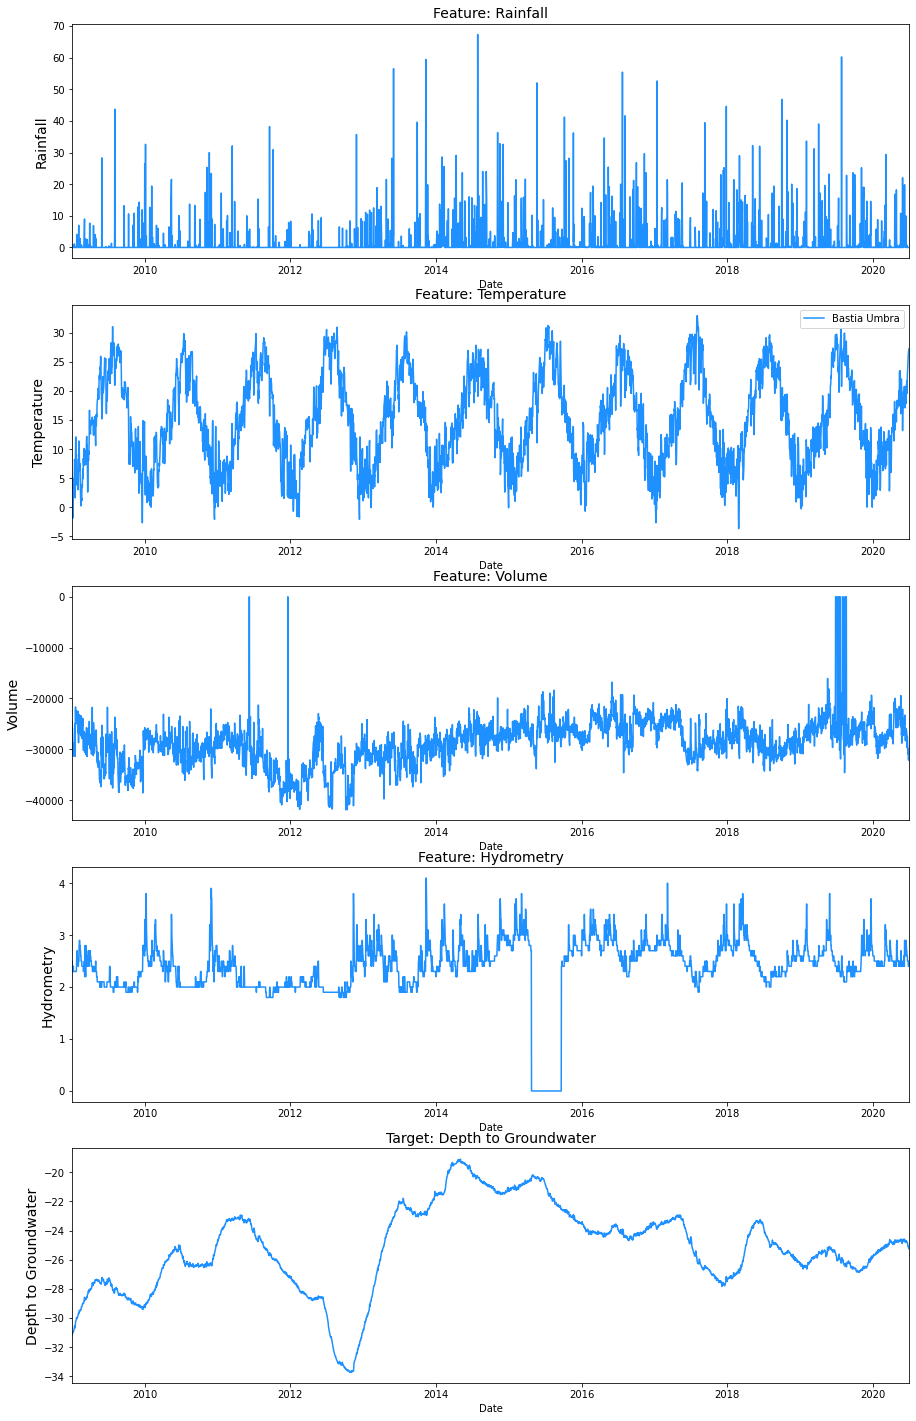

In [9]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)


sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)


sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)


sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

Data Preprocessing

Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data (see Resampling).

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

In [10]:
# Sort values by timestamp (not necessary in this case)
df = df.sort_values(by='Date')

# Check time intervals
df['Time_Interval'] = df.Date - df.Date.shift(1)

df[['Date', 'Time_Interval']].head()

,Date,Time_Interval
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


Handling Missing Values

We can see that Depth_to_Groundwater has missing values.

Furthermore, plotting the time series reveals that there seem to be some implausible zero values for Drainage_Volume, and River_Hydrometry. We will have to clean them by replacing them by nan values and filling them afterwards.

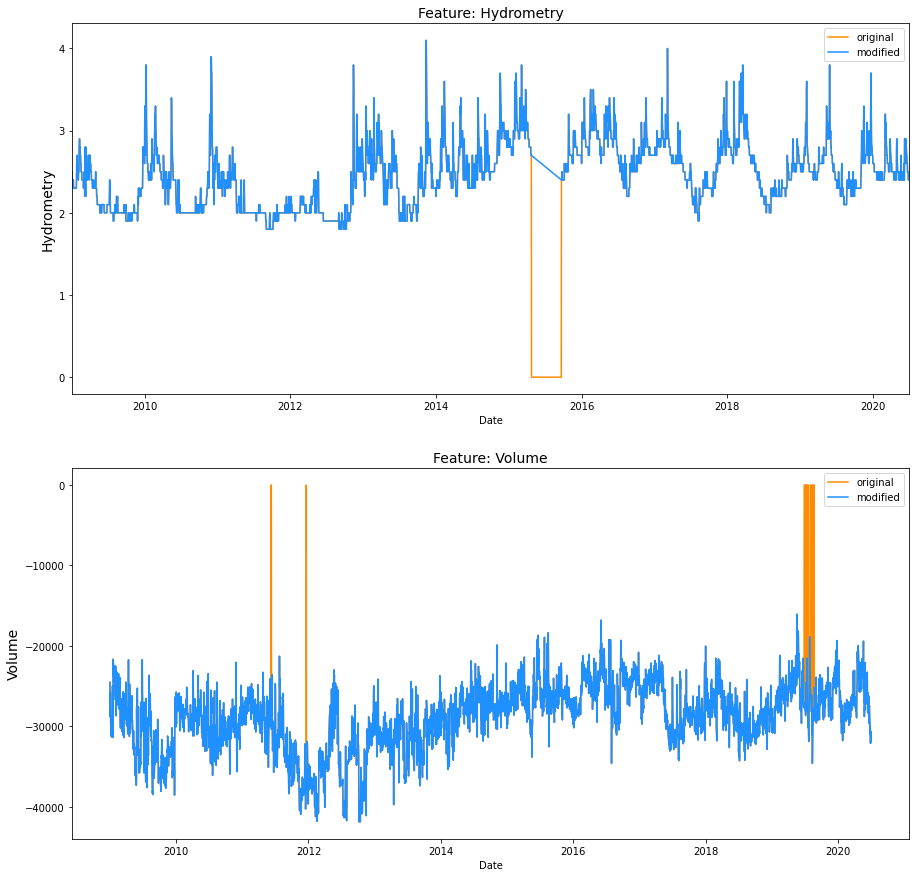

In [11]:

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0),np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'modified')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

    plt.show()

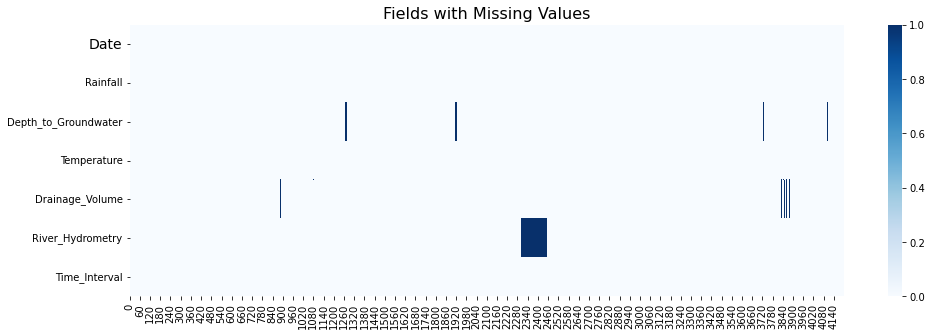

In [13]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    plt.show()

**Option 1: Fill NaN with Outlier or Zero**

In this specific example filling the missing value with an outlier value such as -999 is not a good idea. However, many notebooks in this challenge have been using -999.

**Option 2: Fill NaN with Mean Value**

Also in this example, we can see that filling NaNs with the mean value is also not sufficient.

**Option 3: Fill NaN with Last Value with .ffill()**

Filling NaNs with the last value is already a little bit better in this case.

**Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()**

Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring values.



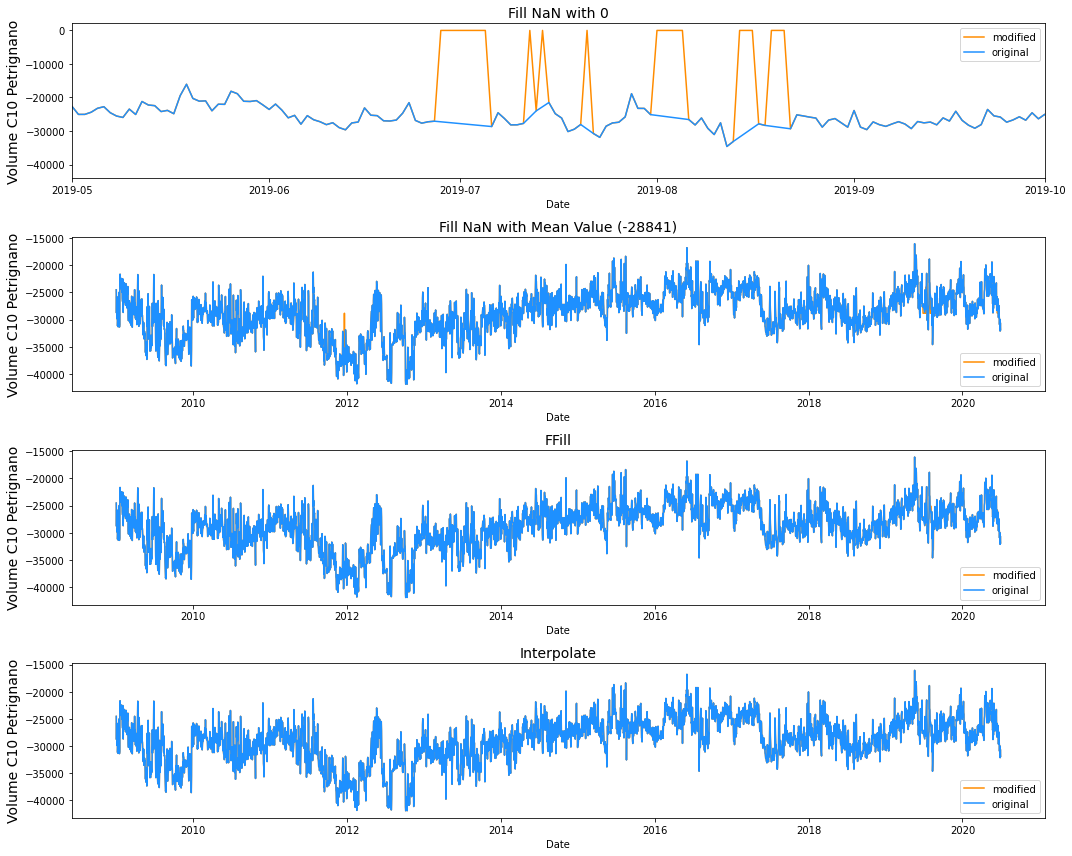

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [14]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    plt.tight_layout()
    plt.show()

In [15]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

## Resampling

Resampling can provide additional information on the data. There are two types of resampling:

***Upsampling*** is when the frequency of samples is increased (e.g. days to hours)

***Downsampling*** is when the frequency of samples is decreased (e.g. days to weeks)

In this example, we will do some downsampling with the .resample() function.

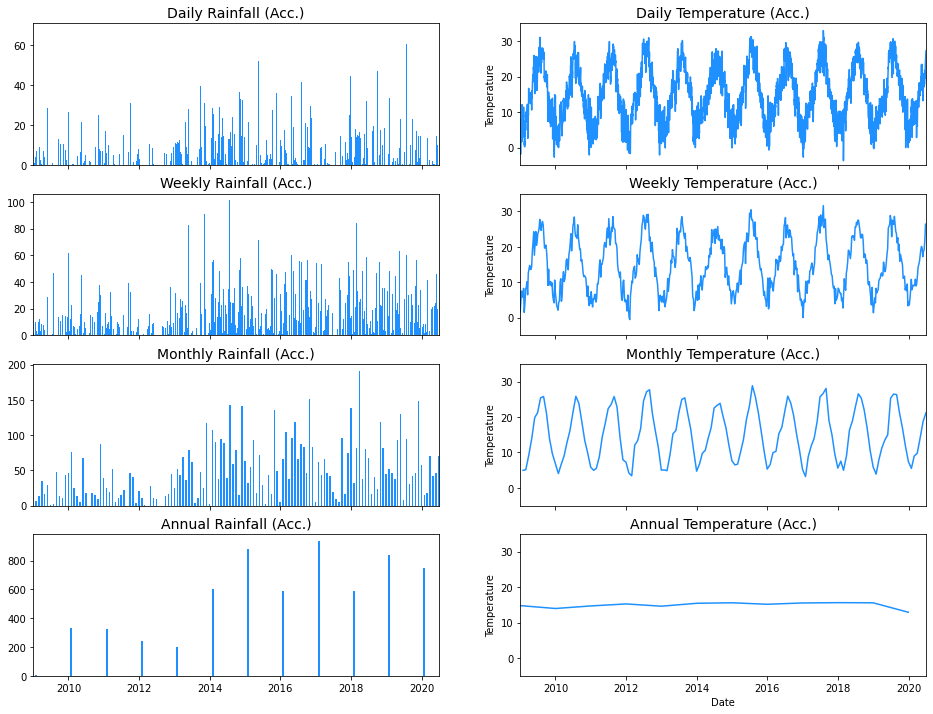

In [17]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))

ax[0, 0].bar(df.Date, df.Rainfall, width=5, color='dodgerblue')
ax[0, 0].set_title('Daily Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)
ax[1, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=10, color='dodgerblue')
ax[1, 0].set_title('Weekly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('M', on='Date').sum().reset_index(drop=False)
ax[2, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=15, color='dodgerblue')
ax[2, 0].set_title('Monthly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('12M', on='Date').sum().reset_index(drop=False)
ax[3, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=20, color='dodgerblue')
ax[3, 0].set_title('Annual Rainfall (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df.Date, df.Temperature, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('365D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[3, 1])
ax[3, 1].set_title('Annual Temperature (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_ylim([-5, 35])

plt.show()

In this example, resampling would not be necessary. On the other hand, there is no necessity to look at the daily data. Considering weekly data seems to be sufficient as well. Therefore, we will downsample the data to a weekly basis.

In [18]:
df_downsampled = df[['Date',
                     'Depth_to_Groundwater', 
                     'Temperature',
                     'Drainage_Volume', 
                     'River_Hydrometry'
                   ]].resample('7D', on='Date').mean().reset_index(drop=False)

df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall'
                               ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df = df_downsampled

**Stationarity**

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.

Time series with trend and/or seasonality are not stationary. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

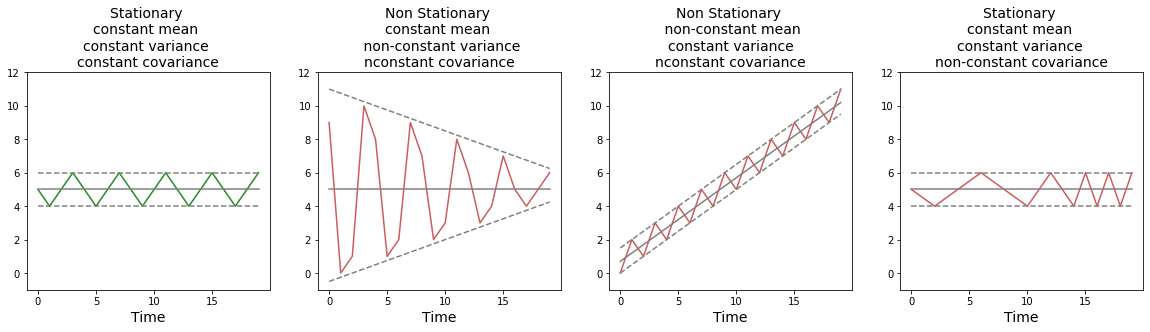

In [20]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)

The check for stationarity can be done via three different approaches:

visually: plot time series and check for trends or seasonality

basic statistics: split time series and compare the mean and variance of each partition

statistical test: Augmented Dickey Fuller test

Let's do the visual check first. We can see that all features except Temperature have non-constant mean and non-constant variance. Therefore, none of these seem to be stationary. However, Temperature shows strong seasonality (hot in summer, cold in winter) and therefore it is not stationary either.

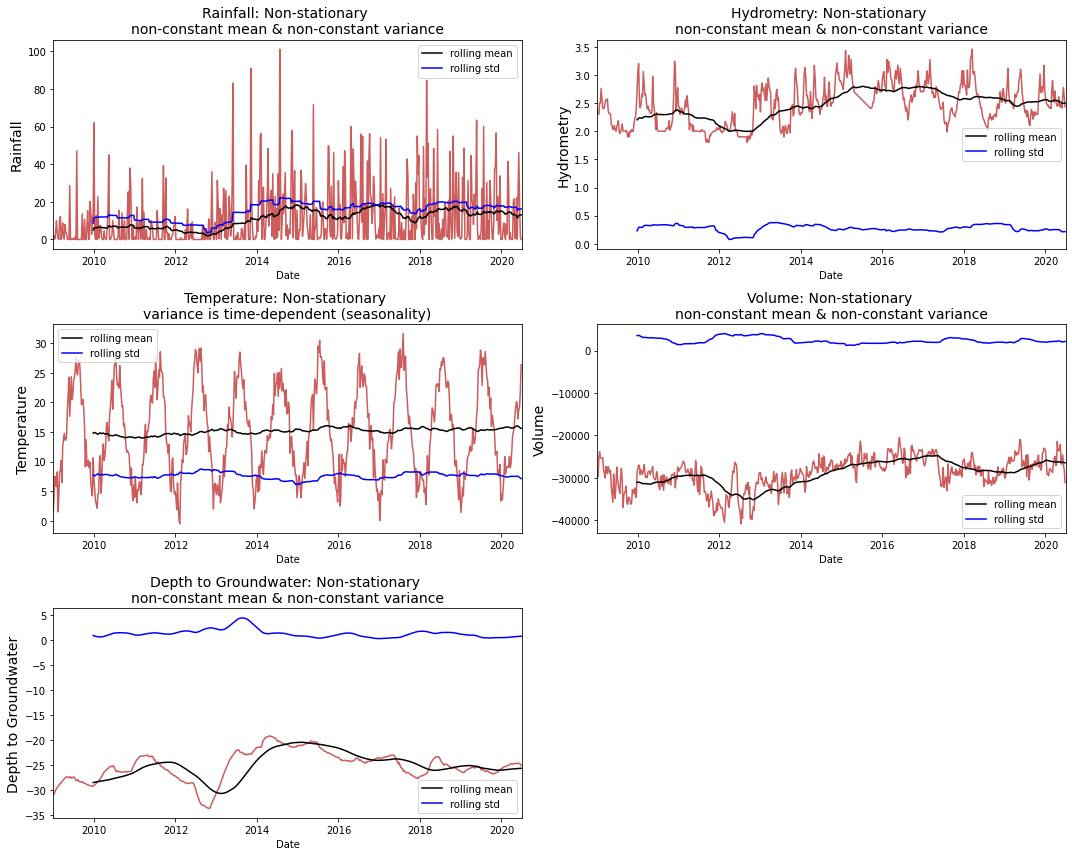

In [21]:
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Rainfall, ax=ax[0, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature, ax=ax[1, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry, ax=ax[0, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume, ax=ax[1, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater, ax=ax[2, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).mean(), ax=ax[2, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).std(), ax=ax[2, 0], color='blue', label='rolling std')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(3):
    ax[i,0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i,1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Next, we will check the underlying statistics. For this we will split the time series into two sections and check the mean and the variance. You could do more partitions if you wanted.

With this method, Temperature and River_Hydrometry show somewhat similar (constant) mean and variance and could be seen as stationary. However, with this method, we are not able to see the seasonality in the Temperature feature.

In [23]:
num_partitions = 2
partition_length = int(len(df) / num_partitions)

partition1_mean = df.head(partition_length).mean()
partition1_var = df.head(partition_length).var()
partition2_mean = df.tail(partition_length).mean()
partition2_var = df.tail(partition_length).var()

In [24]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)


    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
        #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
Depth_to_Groundwater,-26,-24,13,4
Temperature,15,15,58,56
Drainage_Volume,"-30,989","-26,684","12,053,921","5,955,484"
River_Hydrometry,2,3,0,0
Rainfall,8,14,197,306


Let's evaluate the histograms. Since we are looking at the mean and variance, we are expecting that the data conforms to a Gaussian distribution (bell shaped distribution) in case of stationarity.

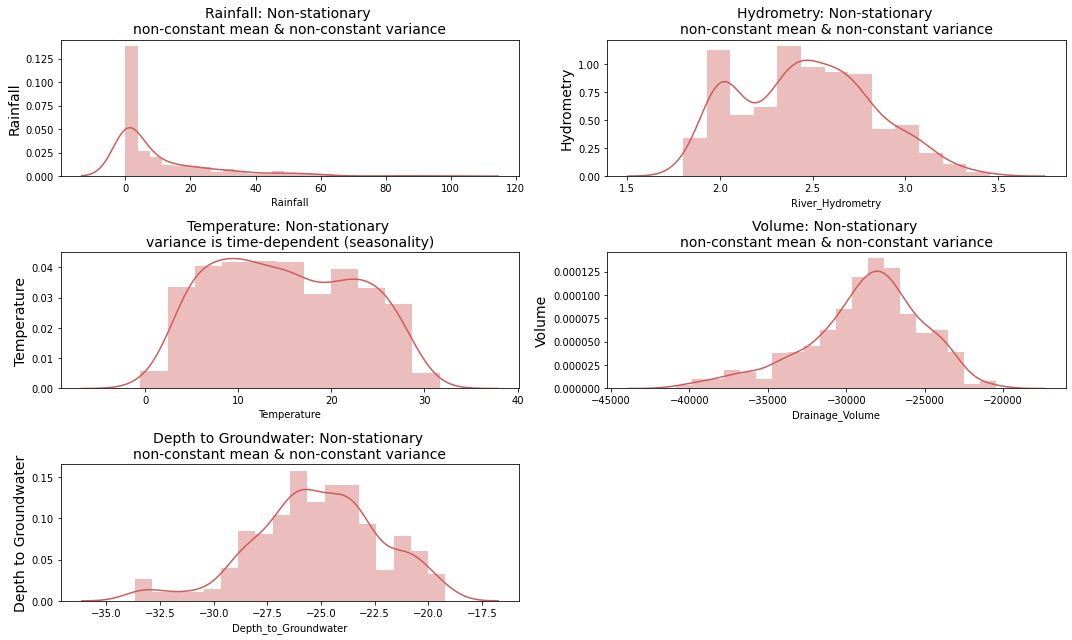

In [25]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df.Rainfall.fillna(np.inf), ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.distplot(df.Temperature.fillna(np.inf), ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.distplot(df.River_Hydrometry.fillna(np.inf), ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.distplot(df.Drainage_Volume.fillna(np.inf), ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.distplot(df.Depth_to_Groundwater.fillna(np.inf), ax=ax[2, 0], color='indianred')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Depth_to_Groundwater.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

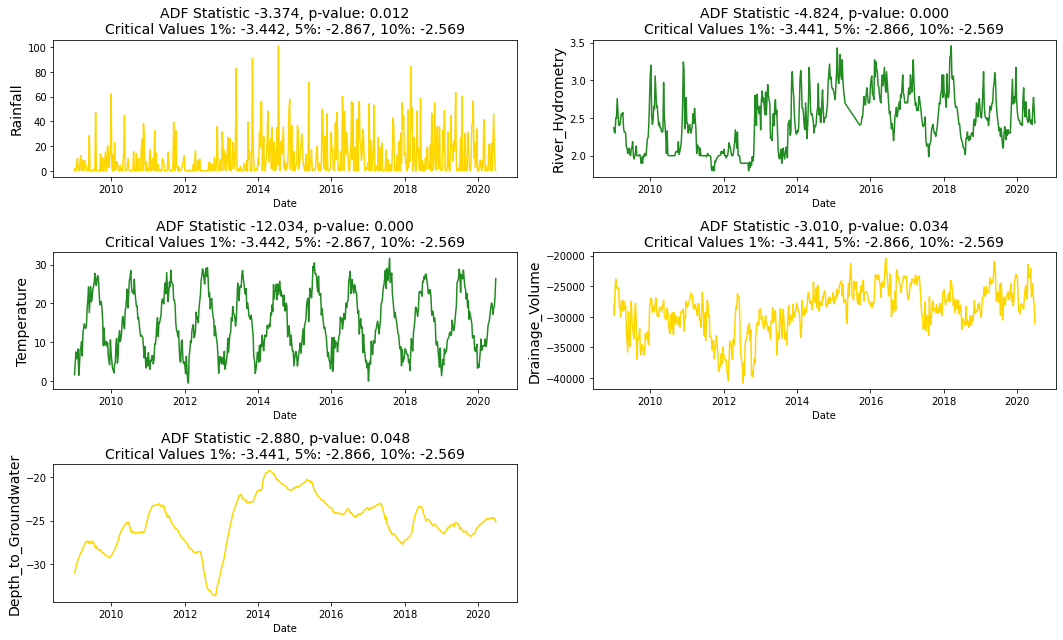

In [28]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

TODO: How to interpret the contradictory results from the different checks...

If the data is not stationary but we want to use a model that requires with characteristic, the data has to be transformed. However, if the data is not stationary to begin with, we should rethink the choice of model.

The two most common methods to achieve stationarity are:

Transformation: e.g. log or square root to stabilize non-constant variance
Differencing: subtracts the current value from the previous

In [29]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['Depth_to_Groundwater_log'] = np.log(abs(df.Depth_to_Groundwater))

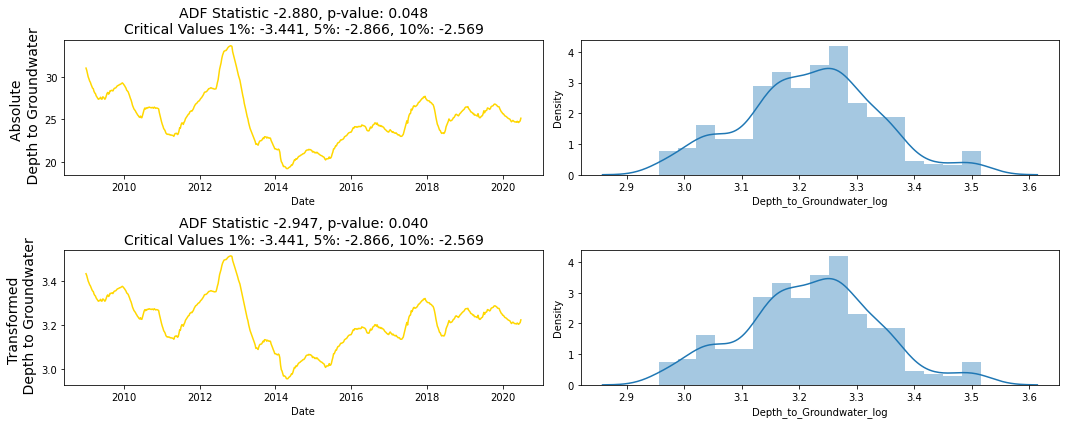

In [30]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
visualize_adfuller_results(abs(df.Depth_to_Groundwater), 'Absolute \n Depth to Groundwater', ax[0, 0])

sns.distplot(df.Depth_to_Groundwater_log, ax=ax[0, 1])
visualize_adfuller_results(df.Depth_to_Groundwater_log, 'Transformed \n Depth to Groundwater', ax[1, 0])

sns.distplot(df.Depth_to_Groundwater_log, ax=ax[1, 1])

plt.tight_layout()
plt.show()

Differencing can be done in different orders:

First order differencing: linear trends with  𝑧𝑖=𝑦𝑖−𝑦𝑖−1 
Second-order differencing: quadratic trends with  𝑧𝑖=(𝑦𝑖−𝑦𝑖−1)−(𝑦𝑖−1−𝑦𝑖−2) 
and so on...

In [31]:
# First Order Differencing
ts_diff = np.diff(df.Depth_to_Groundwater)
df['Depth_to_Groundwater_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(df.Depth_to_Groundwater_diff_1)
df['Depth_to_Groundwater_diff_2'] = np.append([0], ts_diff)

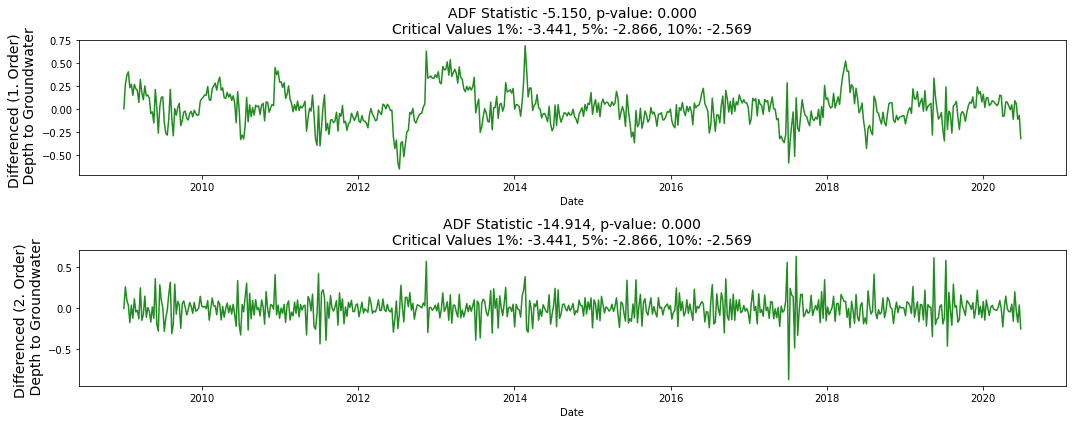

In [32]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

visualize_adfuller_results(df.Depth_to_Groundwater_diff_1, 'Differenced (1. Order) \n Depth to Groundwater', ax[0])
visualize_adfuller_results(df.Depth_to_Groundwater_diff_2, 'Differenced (2. Order) \n Depth to Groundwater', ax[1])
plt.tight_layout()
plt.show()

The differencing can be reverted if the the first value before differencing is known. In this case, we can accumulate all values with the function .cumsum() and add the first value of the original time series.

In [33]:
df.Depth_to_Groundwater.equals(df.Depth_to_Groundwater_diff_1.cumsum() + df.Depth_to_Groundwater.iloc[0])


True

# Feature Engineering

In [34]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df.month%12 // 3 + 1

df[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,Date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


## Encoding Cyclical Features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

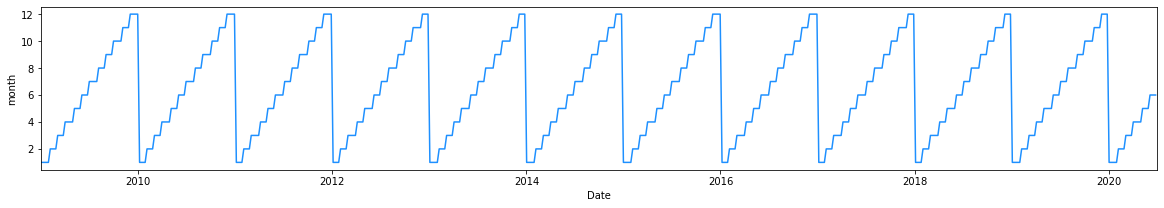

In [35]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df.Date, y=df.month, color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

Ideally, we want the underlying data to represent the same difference between two consecutive months, even between December and January. A common remedy for this issue is to encode cyclical features into two dimensions with sine and cosine transformation.

In [36]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df.month/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df.month/month_in_year)

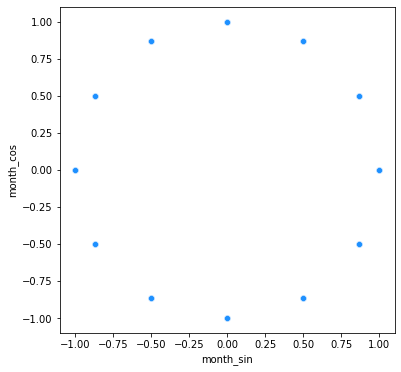

In [37]:
days_in_month = 30
df['day_sin'] = np.sin(2*np.pi*df.day/days_in_month)
df['day_cos'] = np.cos(2*np.pi*df.day/days_in_month)

days_in_year = 365
df['day_of_year_sin'] = np.sin(2*np.pi*df.day_of_year/days_in_year)
df['day_of_year_cos'] = np.cos(2*np.pi*df.day_of_year/days_in_year)

weeks_in_year = 52.1429
df['week_of_year_sin'] = np.sin(2*np.pi*df.week_of_year/weeks_in_year)
df['week_of_year_cos'] = np.cos(2*np.pi*df.week_of_year/weeks_in_year)

quarters_in_year = 4
df['quarter_sin'] = np.sin(2*np.pi*df.quarter/quarters_in_year)
df['quarter_cos'] = np.cos(2*np.pi*df.quarter/quarters_in_year)

seasons_in_year = 4
df['season_sin'] = np.sin(2*np.pi*df.season/seasons_in_year)
df['season_cos'] = np.cos(2*np.pi*df.season/seasons_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()


Decomposition

The characteristics of a time series are

- Trend and Level
- Seasonality
- Random / Noise

We can use the function seasonal_decompose() from the statsmodels library.

Additive:  𝑦(𝑡)=𝐿𝑒𝑣𝑒𝑙+𝑇𝑟𝑒𝑛𝑑+𝑆𝑒𝑎𝑠𝑜𝑛𝑎𝑙𝑖𝑡𝑦+𝑁𝑜𝑖𝑠𝑒 
Multiplicative:  𝑦(𝑡)=𝐿𝑒𝑣𝑒𝑙∗𝑇𝑟𝑒𝑛𝑑∗𝑆𝑒𝑎𝑠𝑜𝑛𝑎𝑙𝑖𝑡𝑦∗𝑁𝑜𝑖𝑠𝑒

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols =  ['Rainfall', 'Temperature', 
                   'Drainage_Volume', 
                    'River_Hydrometry', 'Depth_to_Groundwater']

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], freq=52, model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal

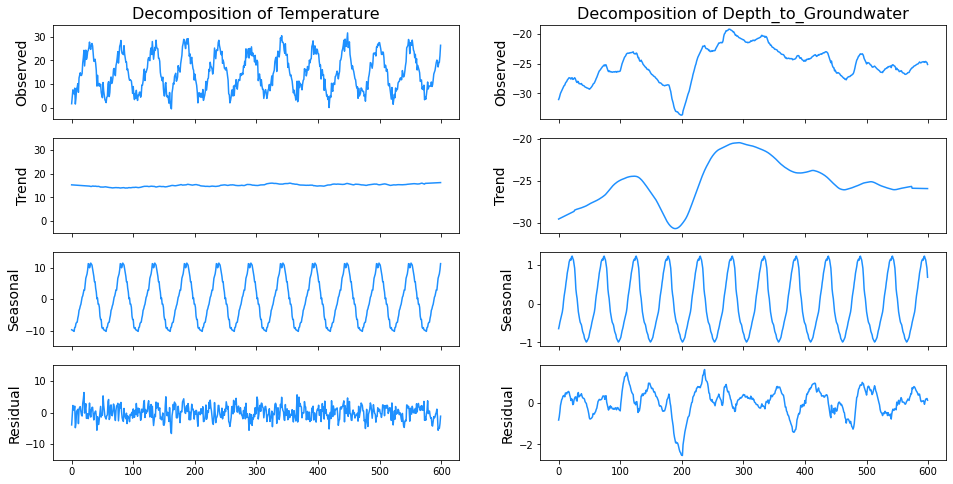

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(df.Temperature, freq=52, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)
ax[0,0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)
ax[1,0].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)
ax[2,0].set_ylim([-15, 15])

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)
ax[3,0].set_ylim([-15, 15])

ax[0,1].set_title('Decomposition of Depth_to_Groundwater', fontsize=16)
res = seasonal_decompose(df.Depth_to_Groundwater, freq=52, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0, 1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
ax[1, 1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2, 1], legend=False, color='dodgerblue')
ax[2, 1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3, 1], legend=False, color='dodgerblue')
ax[3, 1].set_ylabel('Residual', fontsize=14)

plt.show()

In [40]:
df[['Rainfall', 'Rainfall_trend', 'Rainfall_seasonal', 
          'Temperature', 'Temperature_trend', 'Temperature_seasonal', 
                    'Drainage_Volume', 'Drainage_Volume_trend', 'Drainage_Volume_seasonal',
                              'River_Hydrometry', 'River_Hydrometry_trend', 'River_Hydrometry_seasonal', 
                                        'Depth_to_Groundwater', 'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal']].head()\
                                        .style.set_properties(subset=['Rainfall_trend', 'Rainfall_seasonal', 
                                                                      'Temperature_trend', 'Temperature_seasonal', 
                                                                                                    'Drainage_Volume_trend', 'Drainage_Volume_seasonal', 
                                                                                                                                  'River_Hydrometry_trend', 'River_Hydrometry_seasonal',
                                                                                                                                                                'Depth_to_Groundwater_trend', 'Depth_to_Groundwater_seasonal'
                                                                                                                                                                                             ], **{'background-color': 'dodgerblue'})

,Rainfall,Rainfall_trend,Rainfall_seasonal,Temperature,Temperature_trend,Temperature_seasonal,Drainage_Volume,Drainage_Volume_trend,Drainage_Volume_seasonal,River_Hydrometry,River_Hydrometry_trend,River_Hydrometry_seasonal,Depth_to_Groundwater,Depth_to_Groundwater_trend,Depth_to_Groundwater_seasonal
0,0.000000,5.644061,4.822633,1.657143,15.329959,-9.739920,-28164.918857,-32404.467037,1551.335303,2.371429,2.164913,0.207547,-31.048571,-29.571657,-0.643767
1,2.000000,5.663654,-5.096388,4.571429,15.312814,-9.838787,-29755.789714,-32374.371773,938.070633,2.314286,2.167252,0.186527,-30.784286,-29.535110,-0.572078
2,0.200000,5.683247,-5.019971,7.528571,15.295668,-10.002955,-25463.190857,-32344.276508,832.934327,2.300000,2.169592,0.105423,-30.420000,-29.498564,-0.484281
3,4.100000,5.702840,3.454367,6.214286,15.278522,-9.973161,-23854.422857,-32314.181244,518.836188,2.500000,2.171931,0.131993,-30.018571,-29.462017,-0.417712
4,9.900000,5.722433,-3.895493,5.771429,15.261377,-10.246938,-25210.532571,-32284.085980,238.454010,2.500000,2.174270,0.152668,-29.790000,-29.425470,-0.362900


## Lag
.shift()

In [41]:
weeks_in_month = 4

df['Temperature_seasonal_shift_r_2M'] = df.Temperature_seasonal.shift(-2*weeks_in_month)
df['Temperature_seasonal_shift_r_1M'] = df.Temperature_seasonal.shift(-1*weeks_in_month)
df['Temperature_seasonal_shift_1M'] = df.Temperature_seasonal.shift(1*weeks_in_month)
df['Temperature_seasonal_shift_2M'] = df.Temperature_seasonal.shift(2*weeks_in_month)
df['Temperature_seasonal_shift_3M'] = df.Temperature_seasonal.shift(3*weeks_in_month)

Exploratory Data Analysis

Let's begin by plotting the seasonal components of each feature and comparing the minima and maxima. By doing this, we can already gain some insights:

- The depth to groundwater reaches its maximum around May/June and its minimum around November/December
- The temperature reaches its maxmium around August and its minimum around January
- The volume reaches its maximum around June and its minimum around August/September. It takes longer to reach its maximum than to reach its minimum.
The hydrometry reaches its maximum around March and its minimum around September

- The volume and hydrometry reach their minimum roughly around the same time

- The volume and hydrometry reach their minimum when the temperature reaches its maximum

- Temperature lags begind depth to groundwater by around 2 to 3 months

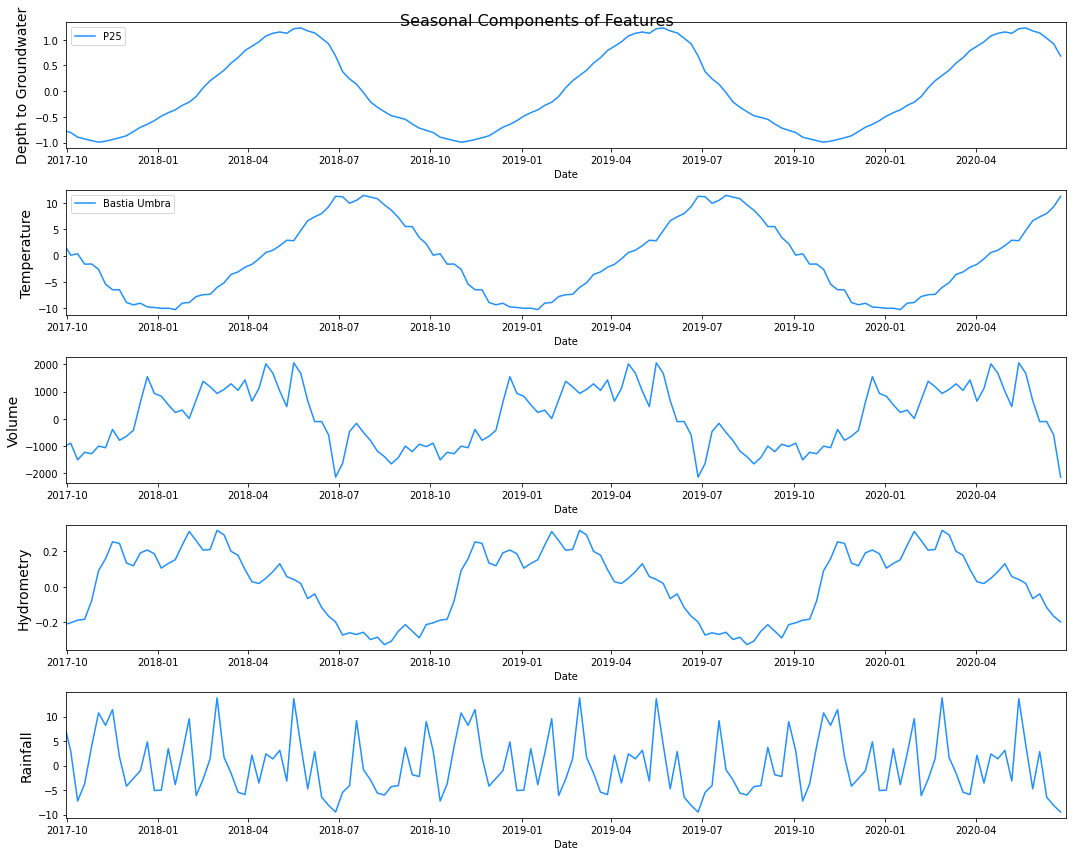

In [43]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater_seasonal, ax=ax[0], color='dodgerblue', label='P25')
ax[0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature_seasonal, ax=ax[1], color='dodgerblue', label='Bastia Umbra')
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume_seasonal, ax=ax[2], color='dodgerblue')
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry_seasonal, ax=ax[3], color='dodgerblue')
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Rainfall_seasonal, ax=ax[4], color='dodgerblue')
ax[4].set_ylabel(ylabel='Rainfall', fontsize=14)

for i in range(5):
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    plt.tight_layout()
plt.show()

We can see that the correlation to the target variables increases if we use the time shifted features in comparison to the original features.

KeyError: ignored

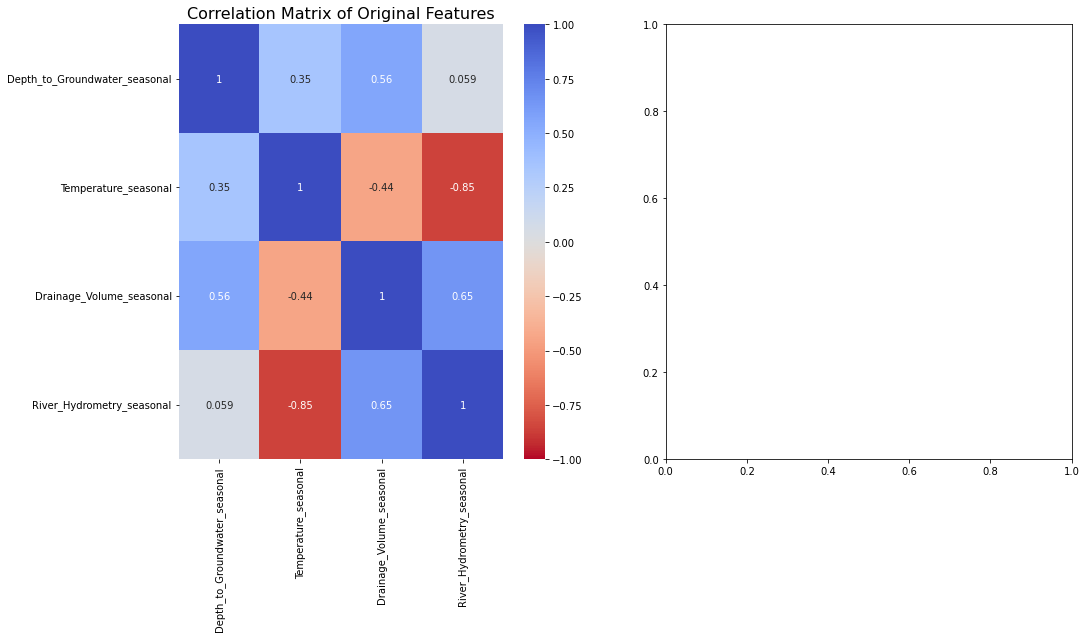

In [47]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

original_cols = ['Depth_to_Groundwater_seasonal', 
                 'Temperature_seasonal',
                 'Drainage_Volume_seasonal', 'River_Hydrometry_seasonal']

corrmat = df[original_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Original Features', fontsize=16)

shifted_cols = [ 'Depth_to_Groundwater_seasonal', 
                 'Temperature_seasonal_shift_r_2M',
                 'Drainage_Volume_seasonal_shift_1M', 'River_Hydrometry_seasonal_shift_3M']

corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Shifted Features', fontsize=16)


plt.tight_layout()
plt.show()

Cross Validation

For cross validation, you can use the Time Series Split library. In Time Series Forecasting: Building Intuition, I go into depth about different types of time series problems and their cross validation methods.

In [51]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df.Date
y = df.Depth_to_Groundwater

folds = TimeSeriesSplit(n_splits=N_SPLITS)

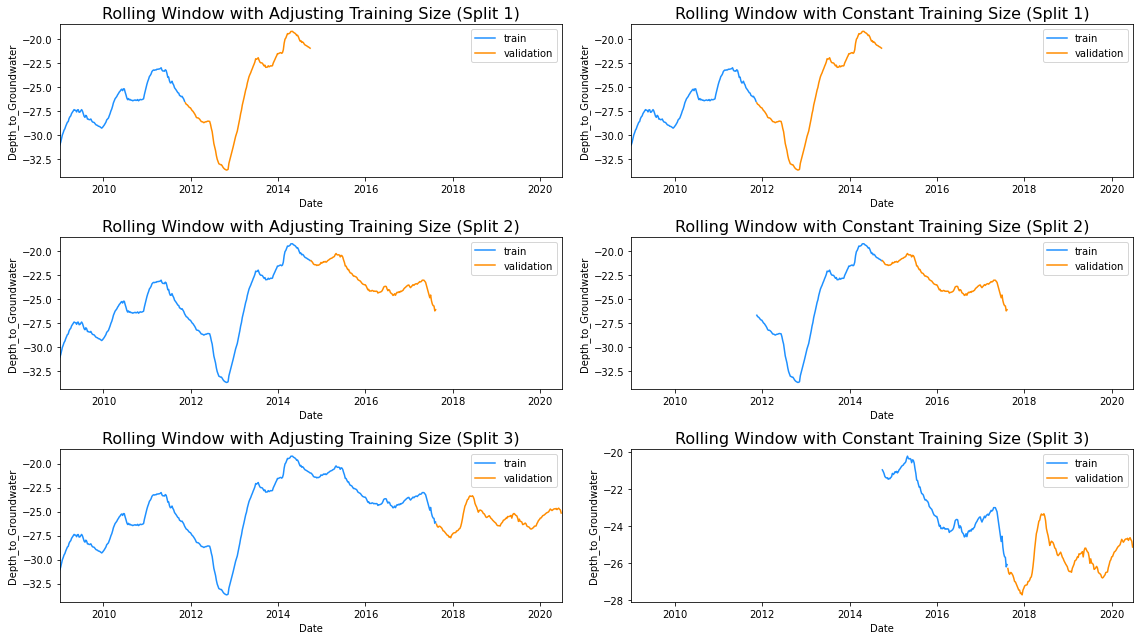

In [53]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
    y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
    ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
        ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
        ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
      ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
      ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
      
plt.tight_layout()
plt.show()